# Word by word text generator with rnn using keras

In [1]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.utils.data_utils import get_file
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import os

Using TensorFlow backend.


# Details of implementation (Functions):
## (You can find below the using of this functions for man and woman)


In [2]:
class Data(object):
    pass

### some global vars

In [3]:
maxlen = 30
step = 3
print("maxlen:",maxlen,"step:", step)

maxlen: 30 step: 3


## function that create the model, first it read the text file with the data,  procces the data for the model, do Vectorization, build the model with 2 stacked LSTM, and return the created model

In [4]:
def build_model(type, data):
    path = type + ".txt"
    filepath = type + "_weights.hdf5"
    try: 
        text = open(path).read().lower()
    except UnicodeDecodeError:
        import codecs
        text = codecs.open(path, encoding='utf-8').read().lower()

    print('corpus length:', len(text))
    data.num_sen = sum(1 for line in codecs.open(path, encoding='utf-8'))
    print('number of sentencase: ', data.num_sen)
    data.chars = set(text)
    data.words = set(text.lower().split())

    print("total number of unique words",len(data.words))
    print("total number of unique chars", len(data.chars))

    data.word_indices = dict((c, i) for i, c in enumerate(data.words))
    data.indices_word = dict((i, c) for i, c in enumerate(data.words))

    sentences = []
    next_words = []
    next_words= []
    sentences1 = []
    list_words = []
    sentences2=[]
    
    data.list_words=text.lower().split()

    for i in range(0,len(data.list_words)-maxlen, step):
        sentences2 = ' '.join(data.list_words[i: i + maxlen])
        sentences.append(sentences2)
        next_words.append((data.list_words[i + maxlen]))
    print('nb sequences(length of sentences):', len(sentences))
    print("length of next_word",len(next_words))

    print('Vectorization...')
    data.X = np.zeros((len(sentences), maxlen, len(data.words)), dtype=np.bool)
    data.y = np.zeros((len(sentences), len(data.words)), dtype=np.bool)
    for i, sentence in enumerate(sentences):
        for t, word in enumerate(sentence.split()):
            data.X[i, t, data.word_indices[word]] = 1
        data.y[i, data.word_indices[next_words[i]]] = 1

    #build the model: 2 stacked LSTM
    print('Build model...')
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(maxlen, len(data.words))))
    model.add(Dropout(0.2))
    model.add(LSTM(512, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(len(data.words)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

    if os.path.isfile(filepath):
       model.load_weights(filepath)
    return model

### helper function to sample an index from a probability array

In [5]:
def sample(a, temperature=1.0):
    a = np.log(a) / temperature
    dist = np.exp(a)/np.sum(np.exp(a)) 
    choices = range(len(a)) 
    return np.random.choice(choices, p=dist)

## function for train the model, we use a chakpoint to save the weights to file becasue it take a lot of time to make the train

In [6]:
def train_model(model,data,type,epochs):
    filepath = type + "_weights.hdf5" 
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    fit = model.fit(data.X, data.y, validation_split=0.05, batch_size=128, epochs=epochs, callbacks=callbacks_list, verbose=1)
    return fit.history

## function for print plot of how accuracy and loss change over training epochs

In [7]:
def print_summery(history):
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left');
    plt.show()
    
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left');
    plt.show()

## function for create sentences

In [8]:
def create_sentence(data, model, diversity = 1.2, num_of_words = 25, verbose = 1):
    start_index = random.randint(0, len(data.list_words) - maxlen - 1)
    if verbose == 1:
        print("Create Sentence..")
        print('Diversity:', diversity)
    generated = ''
    sentence = data.list_words[start_index: start_index + 10]
    seed = ' '.join(sentence)
    if verbose == 1:
        print('Generating with seed:')
        print(seed)       
        
    for i in range(num_of_words):
        x = np.zeros((1, maxlen, len(data.words)))
        for t, word in enumerate(sentence):
            x[0, t, data.word_indices[word]] = 1.

        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_word = data.indices_word[next_index]
        generated += next_word
        generated += " "
        del sentence[0]
        sentence.append(next_word)
    if verbose == 1:
        print("The sentence:")
        print(generated)
    return generated

# Builds models for man and women, and get sentences :

# Men Model :

In [9]:
type = "man"
dataMan = Data()

### Build the model: if we have pre-train data, load it

In [10]:
model = build_model(type, dataMan)

corpus length: 345609
number of sentencase:  18643
total number of unique words 12885
total number of unique chars 111
nb sequences(length of sentences): 23880
length of next_word 23880
Vectorization...
Build model...


### Train the model with 15 iteration (we found that 15 give good result, and no so much time. we can increase the number and get better result, but it take more time). we save the best result to file, if we want to load it fast without need to wait for train. 

In [11]:
history = train_model(model,dataMan,type,15)

Train on 22686 samples, validate on 1194 samples
Epoch 1/15
22656/22686 [============================>.] - ETA: 4s - loss: 7.8258 - acc: 0.0334 
Epoch 00001: loss improved from inf to 7.82544, saving model to man_weights.hdf5
22686/22686 [==============================] - 3185s 140ms/step - loss: 7.8254 - acc: 0.0334 - val_loss: 7.5410 - val_acc: 0.0243
Epoch 2/15
22656/22686 [============================>.] - ETA: 4s - loss: 7.5057 - acc: 0.0347 
Epoch 00002: loss improved from 7.82544 to 7.50538, saving model to man_weights.hdf5
22686/22686 [==============================] - 3108s 137ms/step - loss: 7.5054 - acc: 0.0346 - val_loss: 7.5920 - val_acc: 0.0243
Epoch 3/15
22656/22686 [============================>.] - ETA: 4s - loss: 7.4281 - acc: 0.0352 
Epoch 00003: loss improved from 7.50538 to 7.42825, saving model to man_weights.hdf5
22686/22686 [==============================] - 3192s 141ms/step - loss: 7.4282 - acc: 0.0351 - val_loss: 7.5911 - val_acc: 0.0243
Epoch 4/15
22656/22686

### Print plot of how accuracy and loss change over training epochs

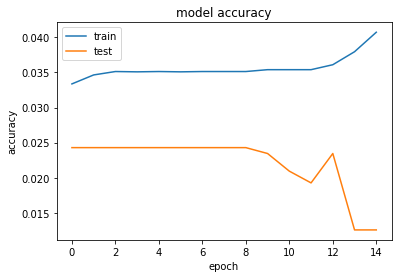

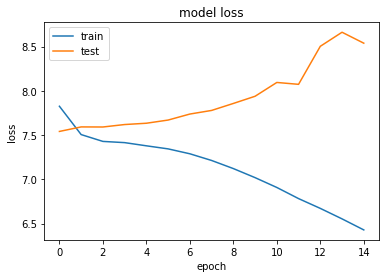

In [12]:
print_summery(history)

### Create sentences, print the first 5 for example

In [13]:
sentences = []
#for i in range(int(0.3 * data.num_sen)):
for i in range(10):
    if i in range(5):
        print("Example " , i, ": ")
        sen = create_sentence(dataMan, model, diversity = 1.2, num_of_words = 25, verbose = 1)
    else:
        sen = create_sentence(dataMan, model, diversity = 1.2, num_of_words = 25, verbose = 0)
    sentences.append(sen)  

Example  0 : 
Create Sentence..
Diversity: 1.2
Generating with seed:
היא לא בדקתי אותה אולי אני לא מריץ טוב הוא
The sentence:
תעטוף אני כבר סיכוי לגשת להוציא popping ללמוד שהוא ויש תרשום איזה תגיש מבחן במקום אמדים בדיקות שאני תביא בת בוא אליפות לישון 2 טובים 
Example  1 : 
Create Sentence..
Diversity: 1.2
Generating with seed:
מזה מקדמים של נגזרת סעיף ג החזקה של h 1
The sentence:
הזה אותי נראית אחרי רואים עושה גול דולר לפה היה כרוני הכבוד שאפשר הרכב 8 דבר שנה משנה 78 לך תשלח לבד טריקים דבר התחיל 
Example  2 : 
Create Sentence..
Diversity: 1.2
Generating with seed:
מאחר לא יודע יעדכנו במייל ניגש היום אני לומד מהבוקר
The sentence:
את טוב הייתי עושים אפשר הזה גיגה מקווה אני כסף אחרי set? רגע בזין סלי נס רשמתי עשית ממני לא אצלך פפל על יום תחפש 
Example  3 : 
Create Sentence..
Diversity: 1.2
Generating with seed:
הזה אני לא מבין פה כלום אני לא בא לבש
The sentence:
אתה כי היום לדברים טעויות מקום אתם מי נקבל אתההה באלגו חופרת הוא רברס עושה האפס מאסמבלי יודע אכפת ליד למה כי חלאס יהיה מהצד 
Exa

### and save to file

In [14]:
np.save(file='man_generate.npy', arr = sentences)

# Woman Model :

In [15]:
type = "women"
dataWoman = Data()

### Build the model: if we have pre-train data, load it

In [ ]:
model = build_model(type,dataWoman)

corpus length: 131205
number of sentencase:  5418
total number of unique words 6170
total number of unique chars 92
nb sequences(length of sentences): 8722
length of next_word 8722
Vectorization...
Build model...


### Train the model with 15 iteration (we found that 15 give good result, and no so much time. we can increase the number and get better result, but it take more time). we save the best result to file, if we want to load it fast without need to wait for train. 

In [ ]:
history = train_model(model,dataWoman,type,15)

Train on 8285 samples, validate on 437 samples
Epoch 1/15
6784/8285 [=======================>......] - ETA: 2:15 - loss: 7.6022 - acc: 0.0264

### Print plot of how accuracy and loss change over training epochs

In [ ]:
print_summery(history)

### Create sentences, print the first 5 for example

In [ ]:
sentences = []
#for i in range(data.num_sen):
for i in range(10):
    if i in range(5):
        print("Example " , i, ": ")
        sen = create_sentence(dataWoman, model, diversity = 1.2, num_of_words = 25, verbose = 1)
    else:
        sen = create_sentence(dataWoman, model, diversity = 1.2, num_of_words = 25, verbose = 0)
    sentences.append(sen)  

### and save to file

In [ ]:
np.save(file='woman_generate.npy', arr = sentences)